In [8]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 111.8 MB/s eta 0:00:00


In [22]:
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
# Helper functions (unchanged)
def softmax(logits: pnp.ndarray, axis: int = -1) -> pnp.ndarray:
    z = logits - pnp.max(logits, axis=axis, keepdims=True)
    e = pnp.exp(z)
    return e / pnp.sum(e, axis=axis, keepdims=True)

def one_hot(y: pnp.ndarray, n_classes: int) -> pnp.ndarray:
    oh = pnp.zeros((y.shape[0], n_classes), dtype=float)
    oh[pnp.arange(y.shape[0]), y.astype(int)] = 1.0
    return oh

def accuracy(y_true: pnp.ndarray, y_pred: pnp.ndarray) -> float:
    return float((y_true.astype(int) == y_pred.astype(int)).mean())

class QNN:
    def __init__(self, n_qubits: int, n_classes: int, q_lr: float, c_lr: float, epochs: int, seed: int):
        self.n_qubits = n_qubits
        self.n_classes = n_classes
        self.q_lr = q_lr # Quantum learning rate
        self.c_lr = c_lr # Classical learning rate
        self.epochs = epochs
        self.rng = pnp.random.default_rng(seed)
        self.dev = qml.device("default.qubit", wires=n_qubits)

        self.theta = None  # Quantum parameters
        self.phi = None    # Classical MLP parameters

        self._encoding = None
        self._measurement = None
        self._layer_builder = None # To store the builder for the single variational layer
        self._layer_shape = None

        self._q_optimizer = qml.AdamOptimizer(stepsize=self.q_lr)

        # Adam state for classical head (manually implemented for simplicity)
        self._c_m: pnp.ndarray = None
        self._c_v: pnp.ndarray = None
        self._c_t: int = 0
        self.classical_layer_shapes = [] # Stores (output_dim, input_dim) for each classical layer

    def add_encoding(self, fn):
        self._encoding = fn
        return self

    def add_layer(self, name: str, shape: tuple, builder):
        n_params = int(pnp.prod(pnp.array(shape)))
        new_params = 0.1 * self.rng.standard_normal(n_params)
        self.theta = new_params if self.theta is None else pnp.concatenate([self.theta, new_params])
        self._layer_builder = builder
        self._layer_shape = shape
        return self

    def add_measurement(self, fn):
        self._measurement = fn
        return self

    def add_classical_mlp(self, layer_dims: list):
        # Build shapes: (out_dim, in_dim) for each classical layer
        shapes = []
        for i in range(1, len(layer_dims)):
            shapes.append((layer_dims[i], layer_dims[i - 1]))
        self.classical_layer_shapes = shapes

        # Count parameters (weights + 1 bias per layer)
        total_params = 0
        for out_dim, in_dim in shapes:
            total_params += out_dim * in_dim + 1 # One bias per layer
        self.phi = 0.1 * self.rng.standard_normal(total_params)

        # Initialize Adam state for classical head
        self._c_m = pnp.zeros_like(self.phi)
        self._c_v = pnp.zeros_like(self.phi)
        self._c_t = 0
        return self

    def _unpack_classical(self, phi: pnp.ndarray) -> list:
        """Return list of (W, b) for each classical layer in order.
        b is a single scalar (shared bias per layer).
        """
        res = []
        idx = 0
        for out_dim, in_dim in self.classical_layer_shapes:
            w_n = out_dim * in_dim
            W = phi[idx : idx + w_n].reshape((out_dim, in_dim))
            idx += w_n
            b = phi[idx] # One bias per layer
            idx += 1
            res.append((W, b))
        return res

    def _classical_forward(self, q_out: pnp.ndarray, phi: pnp.ndarray) -> pnp.ndarray:
        """Forward pass with shared bias per layer and ReLU for hidden layers."""
        layers = self._unpack_classical(phi)
        x = q_out
        for i, (W, b) in enumerate(layers):
            x = pnp.dot(W, x) + b # Scalar bias added to all outputs
            if i < len(layers) - 1: # Apply ReLU for hidden layers
                x = pnp.maximum(x, 0.0)
        return x # Logits

    def _circuit_body(self, x: pnp.ndarray, theta: pnp.ndarray):
        wires = list(range(self.n_qubits))
        self._encoding(wires, x)
        self._layer_builder(wires, theta.reshape(self._layer_shape))
        return pnp.array(self._measurement(wires))

    def compile(self):
        @qml.qnode(self.dev, interface="autograd")
        def qnode(x, theta):
            return self._circuit_body(x, theta)
        self.qnode = qnode
        return self


    def _forward_logits(self, X: pnp.ndarray, theta: pnp.ndarray, phi: pnp.ndarray) -> pnp.ndarray:
        if self.n_qubits > 0 and self.qnode is not None:
            # Quantum forward pass
            outs = [self.qnode(x, theta) for x in X]
        else:
            # Classical-only: just feed X directly
            outs = [x for x in X]
        logits = pnp.stack([self._classical_forward(m, phi) for m in outs], axis=0)
        return logits

    def _loss(self, theta: pnp.ndarray, X: pnp.ndarray, Y_onehot: pnp.ndarray, phi: pnp.ndarray):
        logits = self._forward_logits(X, theta, phi)
        probs = softmax(logits)
        eps = 1e-9
        ce = -pnp.sum(Y_onehot * pnp.log(probs + eps), axis=1)
        return pnp.mean(ce)

    def fit(self, X_train: pnp.ndarray, y_train: pnp.ndarray, X_val: pnp.ndarray, y_val: pnp.ndarray, batch_size: int, grad_clip: float = 1.0):
        Y_train_oh = one_hot(y_train, self.n_classes)
        Y_val_oh = one_hot(y_val, self.n_classes)

        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        theta = self.theta.copy()
        phi = self.phi.copy()
        n = X_train.shape[0]
        indices = pnp.arange(n)

        for epoch in range(1, self.epochs + 1):
            self.rng.shuffle(indices)
            X_shuf = X_train[indices]
            Y_shuf = Y_train_oh[indices]

            for i in range(0, n, batch_size):
                xb = X_shuf[i : i + batch_size]
                yb = Y_shuf[i : i + batch_size]

                def batch_loss(th, ph):
                    return self._loss(th, xb, yb, ph)

                # Quantum gradient and classical gradient
                grad_q = qml.grad(batch_loss, argnum=0)(theta, phi)
                grad_c = qml.grad(batch_loss, argnum=1)(theta, phi)

                # Gradient clipping (joint)
                if grad_clip is not None:
                    gnorm_q = pnp.linalg.norm(grad_q)
                    if gnorm_q > grad_clip:
                        grad_q = grad_q * (grad_clip / (gnorm_q + 1e-12))
                    gnorm_c = pnp.linalg.norm(grad_c)
                    if gnorm_c > grad_clip:
                        grad_c = grad_c * (grad_clip / (gnorm_c + 1e-12))


                # Quantum parameter update via qml optimizer step
                theta = self._q_optimizer.step(lambda th: self._loss(th, xb, yb, phi), theta)

                # Classical parameter update via simplified Adam
                self._c_t += 1
                beta1, beta2, eps = 0.9, 0.999, 1e-8
                self._c_m = beta1 * self._c_m + (1 - beta1) * grad_c
                self._c_v = beta2 * self._c_v + (1 - beta2) * (grad_c ** 2)
                m_hat = self._c_m / (1 - beta1 ** self._c_t)
                v_hat = self._c_v / (1 - beta2 ** self._c_t)
                phi = phi - self.c_lr * m_hat / (pnp.sqrt(v_hat) + eps)


            train_loss = float(self._loss(theta, X_train, Y_train_oh, phi))
            preds_tr = pnp.argmax(softmax(self._forward_logits(X_train, theta, phi)), axis=1)
            train_acc = accuracy(y_train, preds_tr)

            val_loss = float(self._loss(theta, X_val, Y_val_oh, phi))
            preds_val = pnp.argmax(softmax(self._forward_logits(X_val, theta, phi)), axis=1)
            val_acc = accuracy(y_val, preds_val)

            history["loss"].append(train_loss)
            history["acc"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        self.theta = theta
        self.phi = phi
        return history

    def predict(self, X: pnp.ndarray) -> pnp.ndarray:
        logits = self._forward_logits(X, self.theta, self.phi)
        return pnp.argmax(softmax(logits), axis=1)

# ---- Building blocks (simplified, same as before) ----
def default_angle_encoding(gate=None):
    def encode(wires: list, x: pnp.ndarray):
        for i, w in enumerate(wires[:4]):
            if gate == "Rx":
              qml.RX(x[i], wires=w)
            if gate == "Rz":
              qml.RX(x[i], wires=w)
            else:
              qml.RY(x[i], wires=w)
    return encode

def variational_Ry_layer(on_first_k: int):
    def build(wires: list, W: pnp.ndarray):
        target_wires = wires[:on_first_k]
        for idx, w in enumerate(target_wires):
            theta = W[idx]
            qml.RY(theta, wires=w)
    shape = (on_first_k,)
    return shape, build

def variational_Rx_layer(on_first_k: int):
    def build(wires: list, W: pnp.ndarray):
        target_wires = wires[:on_first_k]
        for idx, w in enumerate(target_wires):
            theta = W[idx]
            qml.RX(theta, wires=w)
    shape = (on_first_k,)
    return shape, build

def variational_Rz_layer(on_first_k: int):
    def build(wires: list, W: pnp.ndarray):
        target_wires = wires[:on_first_k]
        for idx, w in enumerate(target_wires):
            theta = W[idx]
            qml.RZ(theta, wires=w)
    shape = (on_first_k,)
    return shape, build

def pauliZ_measurement():
    def measure(wires: list):
        return [qml.expval(qml.PauliZ(w)) for w in wires]
    return measure


Epoch  1 | Train Loss: 0.6548 | Val Loss: 0.6482 | Train Acc: 0.8036 | Val Acc: 0.7895
Epoch  2 | Train Loss: 0.4853 | Val Loss: 0.4915 | Train Acc: 0.8304 | Val Acc: 0.8421
Epoch  3 | Train Loss: 0.3955 | Val Loss: 0.4090 | Train Acc: 0.8571 | Val Acc: 0.8421
Epoch  4 | Train Loss: 0.3427 | Val Loss: 0.3487 | Train Acc: 0.8839 | Val Acc: 0.8421
Epoch  5 | Train Loss: 0.3038 | Val Loss: 0.3132 | Train Acc: 0.9018 | Val Acc: 0.8684
Epoch  6 | Train Loss: 0.2755 | Val Loss: 0.2869 | Train Acc: 0.9196 | Val Acc: 0.8947
Epoch  7 | Train Loss: 0.2521 | Val Loss: 0.2633 | Train Acc: 0.9196 | Val Acc: 0.9211
Epoch  8 | Train Loss: 0.2344 | Val Loss: 0.2505 | Train Acc: 0.9196 | Val Acc: 0.9211
Epoch  9 | Train Loss: 0.2186 | Val Loss: 0.2302 | Train Acc: 0.9375 | Val Acc: 0.9211
Epoch 10 | Train Loss: 0.2059 | Val Loss: 0.2087 | Train Acc: 0.9554 | Val Acc: 0.9474
Epoch 11 | Train Loss: 0.1940 | Val Loss: 0.2072 | Train Acc: 0.9375 | Val Acc: 0.9474
Epoch 12 | Train Loss: 0.1855 | Val Loss: 0

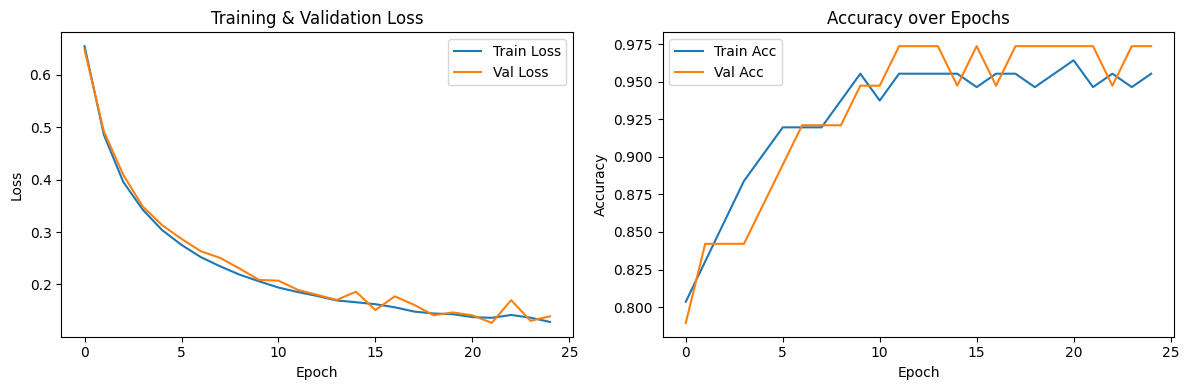


--- Example Quantum Circuit ---
0: ──RY(0.44)──RY(0.51)──┤  <Z>
1: ──RY(1.44)──RY(0.14)──┤  <Z>
2: ──RY(0.32)──RY(0.55)──┤  <Z>
3: ──RY(0.13)──RY(-0.59)─┤  <Z>


In [23]:

if __name__ == "__main__":
    # Load and prepare data
    iris = load_iris()
    X = iris.data.astype(float)
    y = iris.target.astype(int)

    # -------------------------
    # 2) Min–Max normalization to [0, pi]
    # -------------------------
    X_min = X.min(axis=0)   # per-feature min
    X_max = X.max(axis=0)   # per-feature max

    X_norm = (X - X_min) / (X_max - X_min) * np.pi

    X_tr, X_te, y_tr, y_te = train_test_split(X_norm, y, test_size=0.25, random_state=123, stratify=y)

    # QNN Setup - Adjusted learning rates to match original more closely
    qnn = QNN(n_qubits=4, n_classes=3, q_lr=0.1, c_lr=0.05, epochs=25, seed=1)

    qnn.add_encoding(default_angle_encoding("Ry"))

    # Single variational RY layer
    r_shape, r_builder = variational_Ry_layer(on_first_k=4)
    qnn.add_layer("ry_layer", r_shape, r_builder)

    qnn.add_measurement(pauliZ_measurement())

    # Classical head: input dim = n_qubits, one hidden layer of size 4 -> output n_classes
    # This makes the classical head a 2-layer MLP (input -> hidden -> output)
    qnn.add_classical_mlp([qnn.n_qubits, qnn.n_classes]) # Added a hidden layer of size 4

    qnn.compile()

    # Fit the QNN
    hist = qnn.fit(X_tr, y_tr, X_val=X_te, y_val=y_te, batch_size=16, grad_clip=1.0)

    # Evaluate
    y_pred = qnn.predict(X_te)
    print(f"\nFinal Test accuracy: {accuracy(y_te, y_pred):.3f}")

    # Plotting
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist["loss"], label="Train Loss")
    plt.plot(hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist["acc"], label="Train Acc")
    plt.plot(hist["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Draw the quantum circuit
    print("\n--- Example Quantum Circuit ---")
    text_drawer = qml.draw(qnn.qnode)
    print(text_drawer(X_tr[0], qnn.theta))

In [24]:

'''
--- Quantum Circuit (Feature Encoding + Variational Layer) ---
Qubit 0: ──RY(0.44)──RY(0.51)──┤  <Z>
Qubit 1: ──RY(1.44)──RY(0.14)──┤  <Z>
Qubit 2: ──RY(0.32)──RY(0.55)──┤  <Z>
Qubit 3: ──RY(0.13)──RY(-0.59)─┤  <Z>

Measurements: [ ⟨Z₀⟩ , ⟨Z₁⟩ , ⟨Z₂⟩ , ⟨Z₃⟩ ]
                    │
                    ▼
--- Classical Deep Layer ---
[ ⟨Z⟩ values ] ----------→ Dense Layer (3 nodes) ------------→ Softmax ---------------→ Class Probabilities

'''


'\n--- Quantum Circuit (Feature Encoding + Variational Layer) ---\nQubit 0: ──RY(0.44)──RY(0.51)──┤  <Z>\nQubit 1: ──RY(1.44)──RY(0.14)──┤  <Z>\nQubit 2: ──RY(0.32)──RY(0.55)──┤  <Z>\nQubit 3: ──RY(0.13)──RY(-0.59)─┤  <Z>\n\nMeasurements: [ ⟨Z₀⟩ , ⟨Z₁⟩ , ⟨Z₂⟩ , ⟨Z₃⟩ ]\n                    │\n                    ▼\n--- Classical Deep Layer ---\n[ ⟨Z⟩ values ] ----------→ Dense Layer (3 nodes) ------------→ Softmax ---------------→ Class Probabilities\n\n'

Epoch 1/25 - Train Loss: 1.0698, Train Acc: 0.5667 - Val Loss: 0.7421, Val Acc: 0.6667
Epoch 2/25 - Train Loss: 0.6850, Train Acc: 0.8000 - Val Loss: 0.6658, Val Acc: 0.7333
Epoch 3/25 - Train Loss: 0.5965, Train Acc: 0.8083 - Val Loss: 0.6176, Val Acc: 0.7000
Epoch 4/25 - Train Loss: 0.5381, Train Acc: 0.8000 - Val Loss: 0.5815, Val Acc: 0.7667
Epoch 5/25 - Train Loss: 0.4917, Train Acc: 0.8167 - Val Loss: 0.5467, Val Acc: 0.8000
Epoch 6/25 - Train Loss: 0.4537, Train Acc: 0.8333 - Val Loss: 0.5199, Val Acc: 0.8333
Epoch 7/25 - Train Loss: 0.4251, Train Acc: 0.8250 - Val Loss: 0.4968, Val Acc: 0.8333
Epoch 8/25 - Train Loss: 0.4003, Train Acc: 0.8417 - Val Loss: 0.4722, Val Acc: 0.8333
Epoch 9/25 - Train Loss: 0.3799, Train Acc: 0.8500 - Val Loss: 0.4508, Val Acc: 0.8333
Epoch 10/25 - Train Loss: 0.3626, Train Acc: 0.8667 - Val Loss: 0.4310, Val Acc: 0.8333
Epoch 11/25 - Train Loss: 0.3461, Train Acc: 0.8583 - Val Loss: 0.4129, Val Acc: 0.8333
Epoch 12/25 - Train Loss: 0.3310, Train A

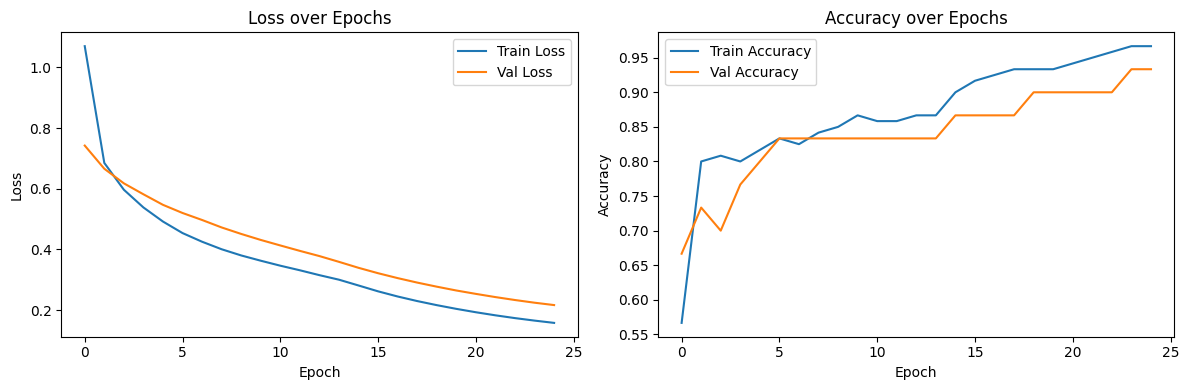

In [57]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# -------------------------
# Utility functions
# -------------------------
def one_hot(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# -------------------------
# Load and preprocess data
# -------------------------
iris = load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train_oh = one_hot(y_train, 3)
y_val_oh = one_hot(y_val, 3)

# -------------------------
# Model parameters
# -------------------------
np.random.seed(42)
input_dim = 4
hidden_dim = 4
output_dim = 3
lr = 0.8
epochs = 25

# Xavier Initialization
W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
b2 = np.zeros((1, output_dim))

# -------------------------
# Track history
# -------------------------
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# -------------------------
# Training loop
# -------------------------
for epoch in range(1, epochs + 1):
    # --- Forward pass (train) ---
    z1 = X_train.dot(W1) + b1
    a1 = relu(z1)
    z2 = a1.dot(W2) + b2
    y_pred_train = softmax(z2)

    # Loss (cross-entropy)
    train_loss = -np.mean(np.sum(y_train_oh * np.log(y_pred_train + 1e-9), axis=1))

    # Backpropagation
    dz2 = y_pred_train - y_train_oh
    dW2 = a1.T.dot(dz2) / X_train.shape[0]
    db2 = np.mean(dz2, axis=0, keepdims=True)

    da1 = dz2.dot(W2.T)
    dz1 = da1 * relu_derivative(z1)
    dW1 = X_train.T.dot(dz1) / X_train.shape[0]
    db1 = np.mean(dz1, axis=0, keepdims=True)

    # print(dW1,dW2,db1,db2)

    # Gradient Descent update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # --- Training metrics ---
    preds_train = np.argmax(y_pred_train, axis=1)
    train_acc = accuracy_score(y_train, preds_train)

    # --- Validation forward pass ---
    z1_val = X_val.dot(W1) + b1
    a1_val = relu(z1_val)
    z2_val = a1_val.dot(W2) + b2
    y_pred_val = softmax(z2_val)

    val_loss = -np.mean(np.sum(y_val_oh * np.log(y_pred_val + 1e-9), axis=1))
    preds_val = np.argmax(y_pred_val, axis=1)
    val_acc = accuracy_score(y_val, preds_val)

    # Record history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)


    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# -------------------------
# Final Evaluation
# -------------------------
print(f"\nFinal Test Accuracy (Validation Set): {val_acc:.4f}")

# -------------------------
# Plot Loss & Accuracy
# -------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
